In [1]:
from __future__ import print_function, division
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import data as dt
import model as md
import copy
from pytorch_ssim import ssim
from torch.utils.data import DataLoader

In [2]:
# print gpu
torch.cuda.set_device(2)
currentDevice = torch.cuda.current_device()
print("Current GPU: " + str(currentDevice))
print(str(torch.cuda.device_count()))
print(str(torch.cuda.get_device_capability(currentDevice)))
print(torch.__version__)

Current GPU: 2
8
(6, 1)
1.0.0


In [4]:
USE_GPU = 1
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:2')
else:
    device = "cpu"
print(device)

cuda:2


In [4]:
# generate csv file, run only for the first time
# dt.generate_csv()

In [5]:
csvFilePath = dt.get_csv_path()
transformed_dataset = dt.HE_SHG_Dataset(csv_file=csvFilePath,
                                               transform=dt.Compose([                                              
                                               dt.Rescale(96),
                                               dt.ToTensor(),
                                               dt.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])                                           
                                           ]))
# TODO: change the normalization parameters

In [6]:
# batchsize 32->16
dataloader = DataLoader(transformed_dataset, batch_size=32,
                        shuffle=True, num_workers=0)

0 torch.Size([32, 3, 96, 96]) torch.Size([32, 96, 96])
1 torch.Size([32, 3, 96, 96]) torch.Size([32, 96, 96])
2 torch.Size([32, 3, 96, 96]) torch.Size([32, 96, 96])
3 torch.Size([32, 3, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


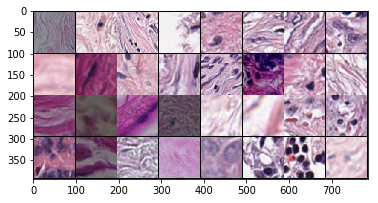

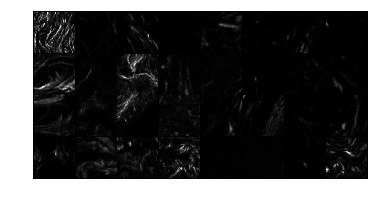

In [7]:
# TODO: insert back mean and variance to plot the image appropriately
dt.show_patch(dataloader) 

In [8]:
print('===> Building model')
model = md.Net().to(device)
criterionMSE = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.005)


===> Building model


In [9]:
def train(epoch):
    epoch_loss = 0
    for iteration, batch in enumerate(dataloader):
        input, target = batch['input'].to(device), batch['output'].to(device)

        optimizer.zero_grad()
        output = model(input)
        targetf = target.float()
        targetf = targetf[:, None]
        
        lossMSE = criterionMSE(output, targetf)      
        lossSSIM = -ssim(output, targetf)
        
        p = 0.25
        loss = p*lossMSE + (1-p)*lossSSIM
        combineLoss = p*lossMSE.item() + (1-p)*lossSSIM.item()
        
        epoch_loss = epoch_loss + combineLoss
        loss.backward()
        optimizer.step()
    
        if iteration%50 == 0:
            print("lossMSE: " + str(p*lossMSE.item()) +
                  " " + "lossSSIM: " + str((1-p)*lossSSIM.item()))
            print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(dataloader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(dataloader)))


In [10]:
# def test():
#     avg_psnr = 0
#     with torch.no_grad():
#         for batch in testing_data_loader:
#             input, target = batch[0].to(device), batch[1].to(device)

#             prediction = model(input)
#             mse = criterion(prediction, target)
#             psnr = 10 * log10(1 / mse.item())
#             avg_psnr += psnr
#     print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))


In [11]:
# def checkpoint(epoch):
#     model_out_path = "model_epoch_{}.pth".format(epoch)
#     torch.save(model, model_out_path)
#     print("Checkpoint saved to {}".format(model_out_path))

In [10]:
for epoch in range(1, 5 + 1):
    train(epoch)
#     test()
#     checkpoint(epoch)

lossMSE: 0.5622570514678955 lossSSIM: 0.07064183615148067
===> Epoch[1](0/25343): Loss: 0.6329
lossMSE: 0.5513356924057007 lossSSIM: 0.029091655276715755
===> Epoch[1](50/25343): Loss: 0.5804
lossMSE: 0.537771999835968 lossSSIM: 0.026364365592598915
===> Epoch[1](100/25343): Loss: 0.5641
lossMSE: 0.5335825681686401 lossSSIM: 0.024731559678912163
===> Epoch[1](150/25343): Loss: 0.5583
lossMSE: 0.5371059775352478 lossSSIM: 0.024059873074293137
===> Epoch[1](200/25343): Loss: 0.5612
lossMSE: 0.5089127421379089 lossSSIM: 0.02246028743684292
===> Epoch[1](250/25343): Loss: 0.5314
lossMSE: 0.521281898021698 lossSSIM: 0.024014325812458992
===> Epoch[1](300/25343): Loss: 0.5453
lossMSE: 0.5109140276908875 lossSSIM: 0.023282065987586975
===> Epoch[1](350/25343): Loss: 0.5342
lossMSE: 0.5139575600624084 lossSSIM: 0.02230474865064025
===> Epoch[1](400/25343): Loss: 0.5363
lossMSE: 0.5002774596214294 lossSSIM: 0.023182764183729887
===> Epoch[1](450/25343): Loss: 0.5235
lossMSE: 0.5001299381256104 

KeyboardInterrupt: 

In [20]:
import matplotlib.pyplot as plt
from torchvision import transforms, utils
def test():
    avg_psnr = 0
    with torch.no_grad():
        for iteration, batch in enumerate(dataloader):
            input, target = batch['input'].to(device), batch['output'].to(device)
                
            prediction = model(input)

            target = target.float()

            outdataloader = {'input':prediction,'output':target}
            
            print(outdataloader['input'].size(), 
                      outdataloader['output'].size())

            plt.figure()
            input_batch, label_batch = outdataloader['input'], outdataloader['output']
            batch_size = 32
            im_size = input_batch.size(2)
            label_batch=label_batch.reshape([batch_size,1,im_size,im_size])
            print(label_batch.size())
            for img in input_batch:
                for t, m, s in zip(img, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):
                    t.mul_(s).add_(m)
                            
            for img in label_batch:
                for t, m, s in zip(img, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):
                    t.mul_(s).add_(m)                           

            grid = utils.make_grid(input_batch).cpu()
            plt.imshow(grid.numpy().transpose((1, 2, 0)))
            plt.figure()

            grid = utils.make_grid(label_batch).cpu()
            plt.imshow(grid.numpy().transpose((1, 2, 0)))

            plt.axis('off')
            plt.ioff()
            plt.show()
            
            targetf = target[:, None]
            
            lossMSE = criterionMSE(prediction, targetf)      
            lossSSIM = -ssim(prediction, targetf)
        
            p = 0.25
            loss = p*lossMSE + (1-p)*lossSSIM
            combineLoss = p*lossMSE.item() + (1-p)*lossSSIM.item()
#             mse = criterion(prediction, target.float())

            psnr = 10 * torch.log10(1 / loss)
            avg_psnr += psnr
            if iteration == 16:
                break
    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(dataloader)))

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


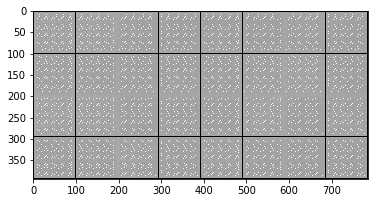

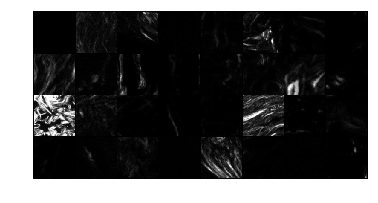

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


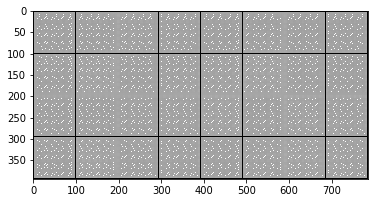

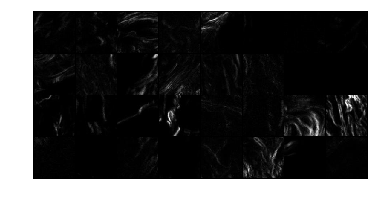

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


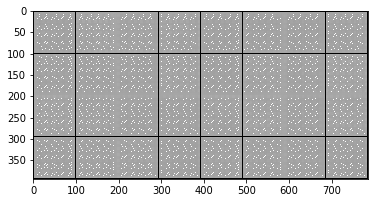

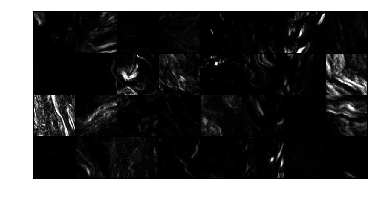

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


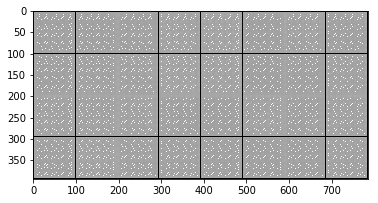

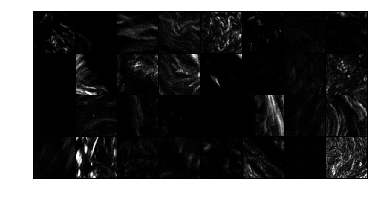

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


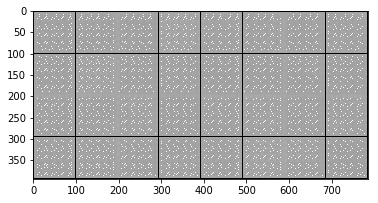

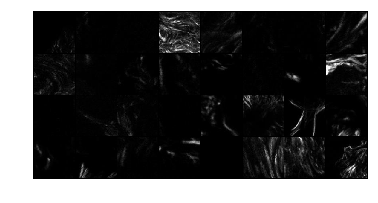

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


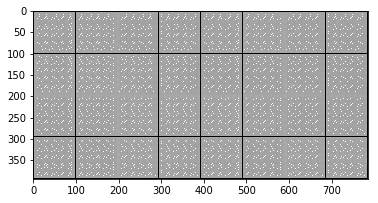

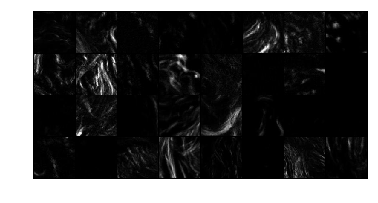

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


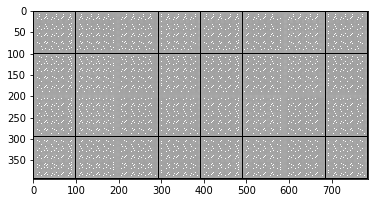

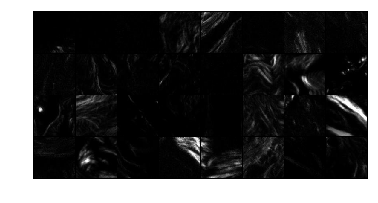

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


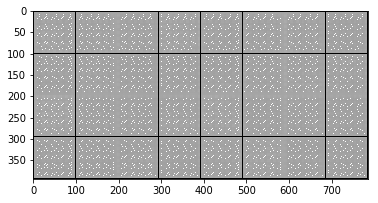

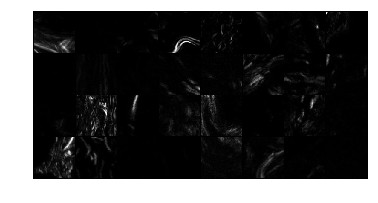

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


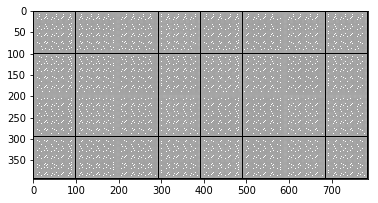

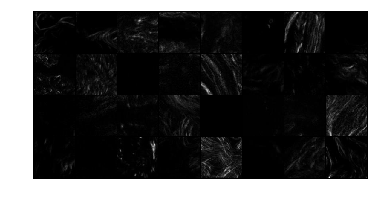

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


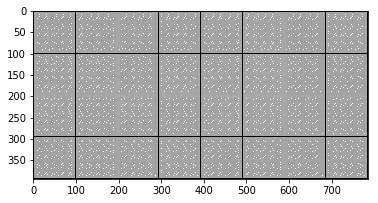

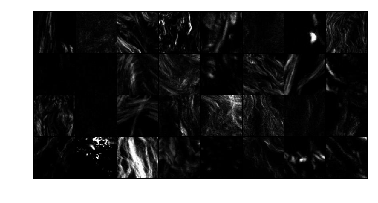

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


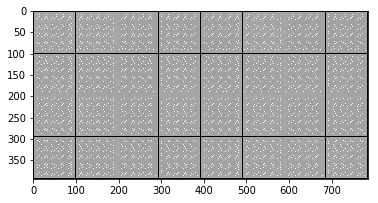

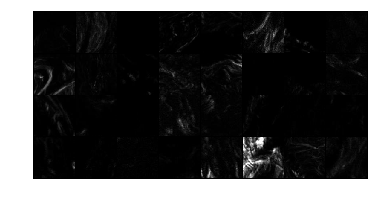

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


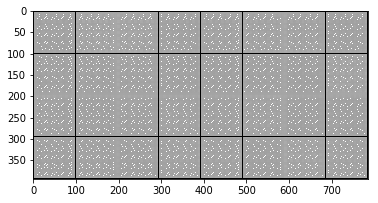

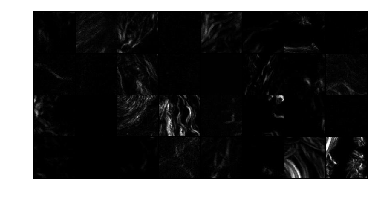

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


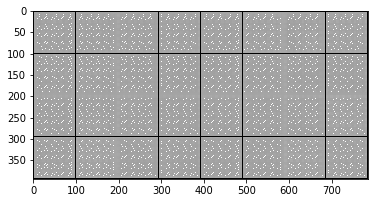

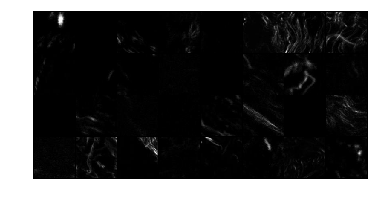

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


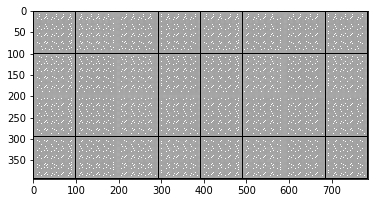

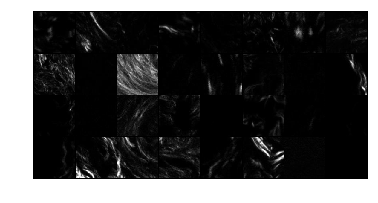

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


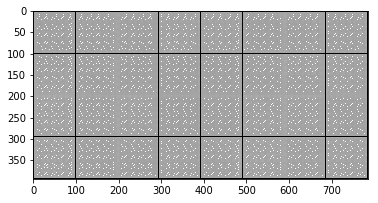

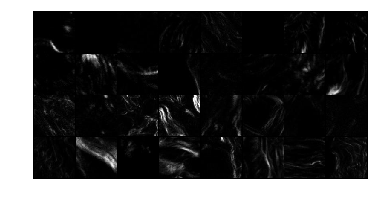

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


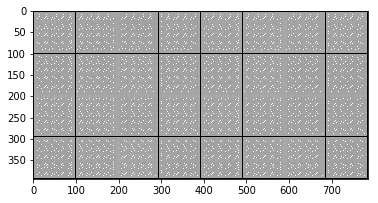

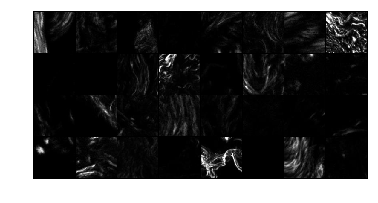

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


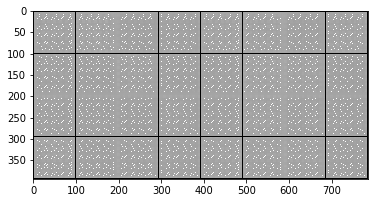

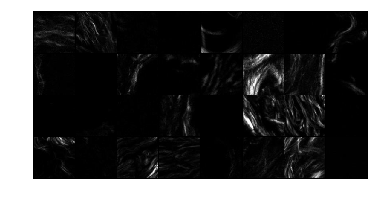

===> Avg. PSNR: 0.0068 dB


In [21]:
test()

In [22]:
# restart
for epoch in range(1, 5 + 1):
    train(epoch)
#     test()
#     checkpoint(epoch)

lossMSE: 0.4024791121482849 lossSSIM: 0.013285013381391764
===> Epoch[1](0/25343): Loss: 0.4158
lossMSE: 0.4079163670539856 lossSSIM: 0.012941282708197832
===> Epoch[1](50/25343): Loss: 0.4209
lossMSE: 0.4029497504234314 lossSSIM: 0.013058004900813103
===> Epoch[1](100/25343): Loss: 0.4160
lossMSE: 0.3943600058555603 lossSSIM: 0.012351583689451218
===> Epoch[1](150/25343): Loss: 0.4067
lossMSE: 0.38638728857040405 lossSSIM: 0.011794013902544975
===> Epoch[1](200/25343): Loss: 0.3982
lossMSE: 0.40278157591819763 lossSSIM: 0.011765838135033846
===> Epoch[1](250/25343): Loss: 0.4145
lossMSE: 0.39697393774986267 lossSSIM: 0.012090745847672224
===> Epoch[1](300/25343): Loss: 0.4091
lossMSE: 0.39133894443511963 lossSSIM: 0.011706587858498096
===> Epoch[1](350/25343): Loss: 0.4030
lossMSE: 0.3863323926925659 lossSSIM: 0.010711137671023607
===> Epoch[1](400/25343): Loss: 0.3970
lossMSE: 0.39665380120277405 lossSSIM: 0.011119351722300053
===> Epoch[1](450/25343): Loss: 0.4078
lossMSE: 0.3872717

lossMSE: 0.29958340525627136 lossSSIM: 0.0033518298296257854
===> Epoch[1](4150/25343): Loss: 0.3029
lossMSE: 0.28955531120300293 lossSSIM: 0.0032848503906279802
===> Epoch[1](4200/25343): Loss: 0.2928
lossMSE: 0.288776695728302 lossSSIM: 0.003164749941788614
===> Epoch[1](4250/25343): Loss: 0.2919
lossMSE: 0.2943645119667053 lossSSIM: 0.00309366371948272
===> Epoch[1](4300/25343): Loss: 0.2975
lossMSE: 0.29881131649017334 lossSSIM: 0.0032786634983494878
===> Epoch[1](4350/25343): Loss: 0.3021
lossMSE: 0.29224464297294617 lossSSIM: 0.003294352674856782
===> Epoch[1](4400/25343): Loss: 0.2955
lossMSE: 0.2874404191970825 lossSSIM: 0.0032565268920734525
===> Epoch[1](4450/25343): Loss: 0.2907
lossMSE: 0.29017549753189087 lossSSIM: 0.0032907177228480577
===> Epoch[1](4500/25343): Loss: 0.2935
lossMSE: 0.28278329968452454 lossSSIM: 0.0033647260861471295
===> Epoch[1](4550/25343): Loss: 0.2861
lossMSE: 0.2859894335269928 lossSSIM: 0.0030434089712798595
===> Epoch[1](4600/25343): Loss: 0.2890

lossMSE: 0.27104824781417847 lossSSIM: 0.0018884726450778544
===> Epoch[1](8250/25343): Loss: 0.2729
lossMSE: 0.2652362585067749 lossSSIM: 0.0018570654792711139
===> Epoch[1](8300/25343): Loss: 0.2671
lossMSE: 0.2618444561958313 lossSSIM: 0.0018168794922530651
===> Epoch[1](8350/25343): Loss: 0.2637
lossMSE: 0.2680487632751465 lossSSIM: 0.0019005280919373035
===> Epoch[1](8400/25343): Loss: 0.2699
lossMSE: 0.2633730173110962 lossSSIM: 0.0017825886025093496
===> Epoch[1](8450/25343): Loss: 0.2652
lossMSE: 0.265957236289978 lossSSIM: 0.0018202460487373173
===> Epoch[1](8500/25343): Loss: 0.2678
lossMSE: 0.270090788602829 lossSSIM: 0.0018678653868846595
===> Epoch[1](8550/25343): Loss: 0.2720
lossMSE: 0.26737290620803833 lossSSIM: 0.0016862842021510005
===> Epoch[1](8600/25343): Loss: 0.2691
lossMSE: 0.2737921476364136 lossSSIM: 0.0017972117057070136
===> Epoch[1](8650/25343): Loss: 0.2756
lossMSE: 0.2758892774581909 lossSSIM: 0.0017972055939026177
===> Epoch[1](8700/25343): Loss: 0.2777


lossMSE: 0.26622670888900757 lossSSIM: 0.0016157826175913215
===> Epoch[1](12350/25343): Loss: 0.2678
lossMSE: 0.2599722146987915 lossSSIM: 0.0014858156209811568
===> Epoch[1](12400/25343): Loss: 0.2615
lossMSE: 0.26116639375686646 lossSSIM: 0.001578133029397577
===> Epoch[1](12450/25343): Loss: 0.2627
lossMSE: 0.2612411379814148 lossSSIM: 0.0014369031123351306
===> Epoch[1](12500/25343): Loss: 0.2627
lossMSE: 0.2663532495498657 lossSSIM: 0.0015054299728944898
===> Epoch[1](12550/25343): Loss: 0.2679
lossMSE: 0.26046404242515564 lossSSIM: 0.0016009229002520442
===> Epoch[1](12600/25343): Loss: 0.2621
lossMSE: 0.26962417364120483 lossSSIM: 0.00142337751458399
===> Epoch[1](12650/25343): Loss: 0.2710
lossMSE: 0.272601455450058 lossSSIM: 0.001504534506238997
===> Epoch[1](12700/25343): Loss: 0.2741
lossMSE: 0.25950899720191956 lossSSIM: 0.001500792510341853
===> Epoch[1](12750/25343): Loss: 0.2610
lossMSE: 0.2564416825771332 lossSSIM: 0.0015179261681623757
===> Epoch[1](12800/25343): Loss

lossMSE: 0.25907546281814575 lossSSIM: 0.0015008501359261572
===> Epoch[1](16400/25343): Loss: 0.2606
lossMSE: 0.2635578215122223 lossSSIM: 0.0014713648706674576
===> Epoch[1](16450/25343): Loss: 0.2650
lossMSE: 0.2649681270122528 lossSSIM: 0.0014297148445621133
===> Epoch[1](16500/25343): Loss: 0.2664
lossMSE: 0.26547855138778687 lossSSIM: 0.001376743835862726
===> Epoch[1](16550/25343): Loss: 0.2669
lossMSE: 0.2638476490974426 lossSSIM: 0.0013992873136885464
===> Epoch[1](16600/25343): Loss: 0.2652
lossMSE: 0.2705738842487335 lossSSIM: 0.0014569697377737612
===> Epoch[1](16650/25343): Loss: 0.2720
lossMSE: 0.25189587473869324 lossSSIM: 0.0015106435166671872
===> Epoch[1](16700/25343): Loss: 0.2534
lossMSE: 0.2582364082336426 lossSSIM: 0.0014818764757364988
===> Epoch[1](16750/25343): Loss: 0.2597
lossMSE: 0.2621102035045624 lossSSIM: 0.0014426471607293934
===> Epoch[1](16800/25343): Loss: 0.2636
lossMSE: 0.26054155826568604 lossSSIM: 0.0012267486308701336
===> Epoch[1](16850/25343): 

lossMSE: 0.2647043466567993 lossSSIM: 0.0013153607142157853
===> Epoch[1](20500/25343): Loss: 0.2660
lossMSE: 0.2634751498699188 lossSSIM: 0.001284374127862975
===> Epoch[1](20550/25343): Loss: 0.2648
lossMSE: 0.2702058255672455 lossSSIM: 0.0014662316534668207
===> Epoch[1](20600/25343): Loss: 0.2717
lossMSE: 0.2507511377334595 lossSSIM: 0.0015287934802472591
===> Epoch[1](20650/25343): Loss: 0.2523
lossMSE: 0.2572825253009796 lossSSIM: 0.0013731099315918982
===> Epoch[1](20700/25343): Loss: 0.2587
lossMSE: 0.26217493414878845 lossSSIM: 0.0014709174865856767
===> Epoch[1](20750/25343): Loss: 0.2636
lossMSE: 0.26901254057884216 lossSSIM: 0.00141216951305978
===> Epoch[1](20800/25343): Loss: 0.2704
lossMSE: 0.25187423825263977 lossSSIM: 0.0015561249456368387
===> Epoch[1](20850/25343): Loss: 0.2534
lossMSE: 0.268393874168396 lossSSIM: 0.0014324399235192686
===> Epoch[1](20900/25343): Loss: 0.2698
lossMSE: 0.26499587297439575 lossSSIM: 0.0013965535908937454
===> Epoch[1](20950/25343): Los

lossMSE: 0.2650553286075592 lossSSIM: 0.0014947035815566778
===> Epoch[1](24600/25343): Loss: 0.2666
lossMSE: 0.2586122751235962 lossSSIM: 0.0015886006294749677
===> Epoch[1](24650/25343): Loss: 0.2602
lossMSE: 0.2656457722187042 lossSSIM: 0.0014516712399199605
===> Epoch[1](24700/25343): Loss: 0.2671
lossMSE: 0.24934345483779907 lossSSIM: 0.0015784450806677341
===> Epoch[1](24750/25343): Loss: 0.2509
lossMSE: 0.2559545338153839 lossSSIM: 0.0014546608726959676
===> Epoch[1](24800/25343): Loss: 0.2574
lossMSE: 0.25799381732940674 lossSSIM: 0.001473445852752775
===> Epoch[1](24850/25343): Loss: 0.2595
lossMSE: 0.25938650965690613 lossSSIM: 0.00147196400212124
===> Epoch[1](24900/25343): Loss: 0.2609
lossMSE: 0.2697165310382843 lossSSIM: 0.0014458552468568087
===> Epoch[1](24950/25343): Loss: 0.2712
lossMSE: 0.2588086724281311 lossSSIM: 0.0013644365826621652
===> Epoch[1](25000/25343): Loss: 0.2602
lossMSE: 0.26529595255851746 lossSSIM: 0.0014316556917037815
===> Epoch[1](25050/25343): Lo

lossMSE: 0.2632540464401245 lossSSIM: 0.0014745845692232251
===> Epoch[2](3350/25343): Loss: 0.2647
lossMSE: 0.25720202922821045 lossSSIM: 0.0013924590311944485
===> Epoch[2](3400/25343): Loss: 0.2586
lossMSE: 0.26134350895881653 lossSSIM: 0.0014160696300677955
===> Epoch[2](3450/25343): Loss: 0.2628
lossMSE: 0.26216739416122437 lossSSIM: 0.0014314828149508685
===> Epoch[2](3500/25343): Loss: 0.2636
lossMSE: 0.26308169960975647 lossSSIM: 0.0015720846131443977
===> Epoch[2](3550/25343): Loss: 0.2647


KeyboardInterrupt: 

In [23]:
import matplotlib.pyplot as plt
from torchvision import transforms, utils
def test():
    avg_psnr = 0
    with torch.no_grad():
        for iteration, batch in enumerate(dataloader):
            input, target = batch['input'].to(device), batch['output'].to(device)
                
            prediction = model(input)

            target = target.float()

            outdataloader = {'input':prediction,'output':target}
            
            print(outdataloader['input'].size(), 
                      outdataloader['output'].size())

            plt.figure()
            input_batch, label_batch = outdataloader['input'], outdataloader['output']
            batch_size = 32
            im_size = input_batch.size(2)
            label_batch=label_batch.reshape([batch_size,1,im_size,im_size])
            print(label_batch.size())
            for img in input_batch:
                for t, m, s in zip(img, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):
                    t.mul_(s).add_(m)
                            
            for img in label_batch:
                for t, m, s in zip(img, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):
                    t.mul_(s).add_(m)                           

            grid = utils.make_grid(input_batch).cpu()
            plt.imshow(grid.numpy().transpose((1, 2, 0)))
            plt.figure()

            grid = utils.make_grid(label_batch).cpu()
            plt.imshow(grid.numpy().transpose((1, 2, 0)))

            plt.axis('off')
            plt.ioff()
            plt.show()
            
            targetf = target[:, None]
            
            lossMSE = criterionMSE(prediction, targetf)      
            lossSSIM = -ssim(prediction, targetf)
        
            p = 0.25
            loss = p*lossMSE + (1-p)*lossSSIM
            combineLoss = p*lossMSE.item() + (1-p)*lossSSIM.item()
#             mse = criterion(prediction, target.float())

            psnr = 10 * torch.log10(1 / loss)
            avg_psnr += psnr
            if iteration == 16:
                break
    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(dataloader)))

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


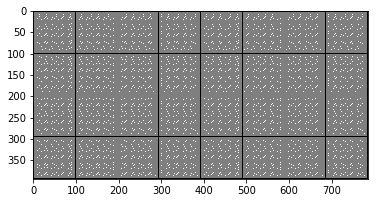

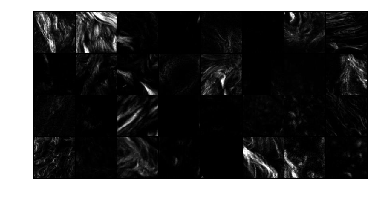

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


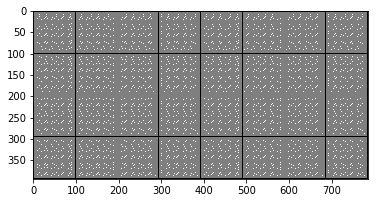

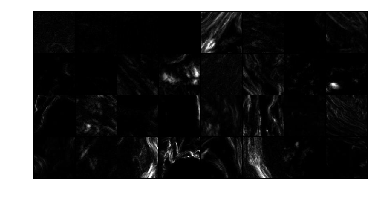

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


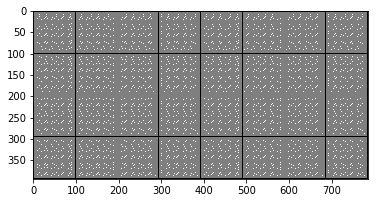

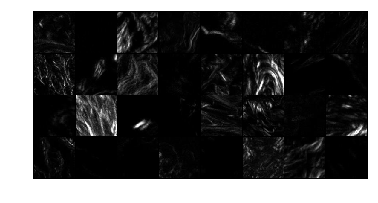

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


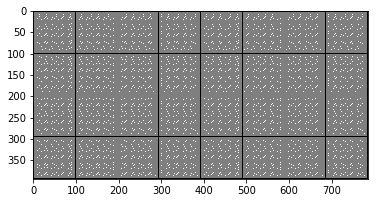

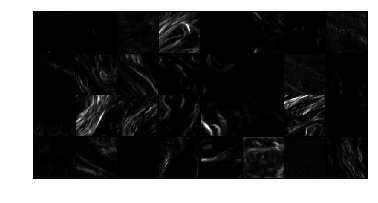

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


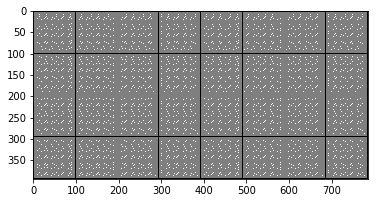

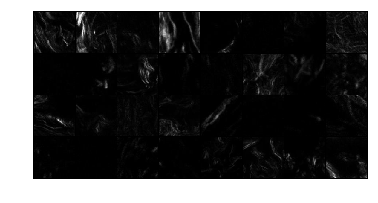

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


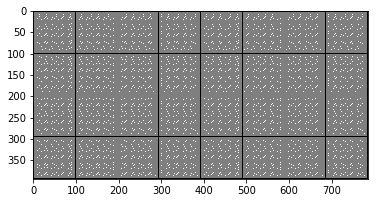

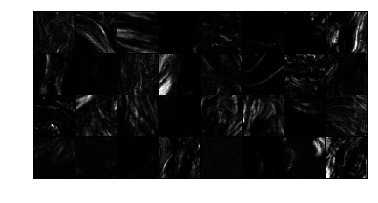

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


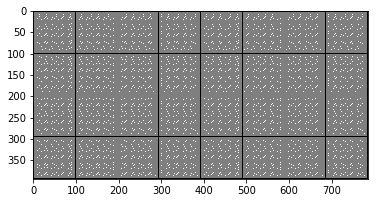

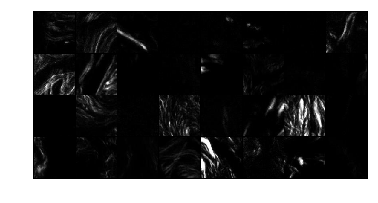

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


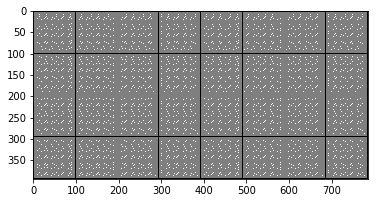

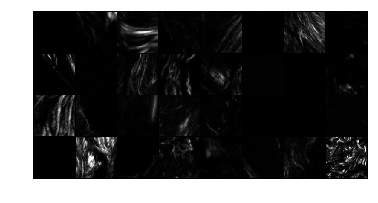

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


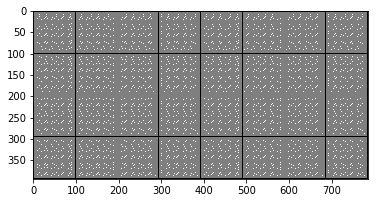

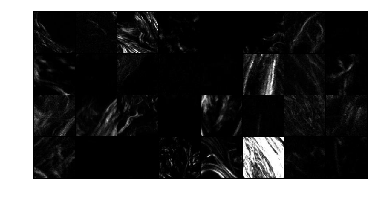

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


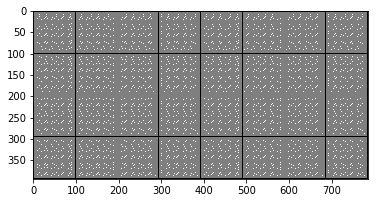

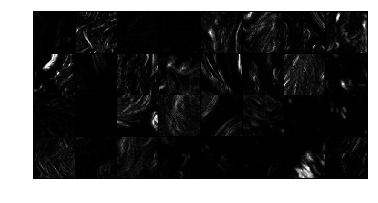

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


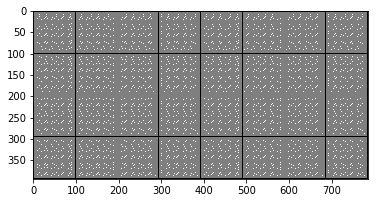

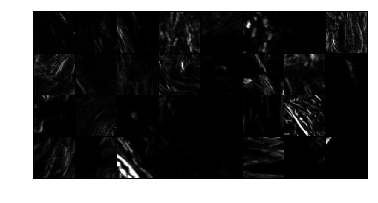

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


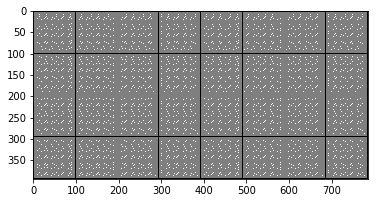

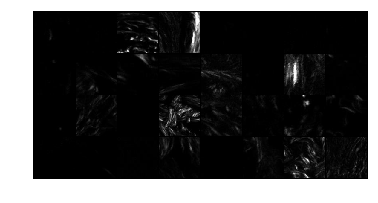

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


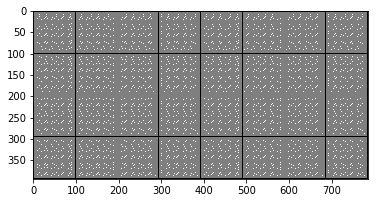

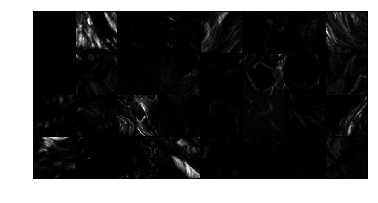

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


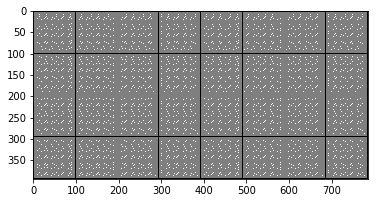

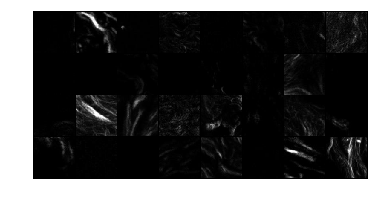

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


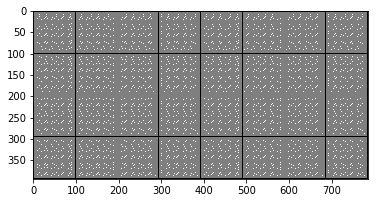

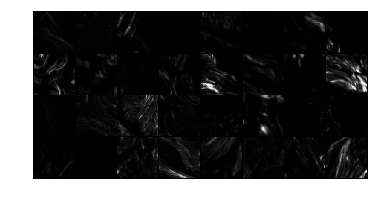

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


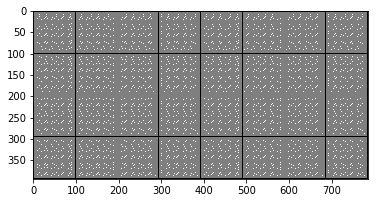

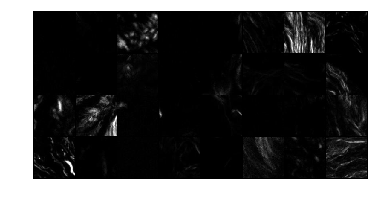

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


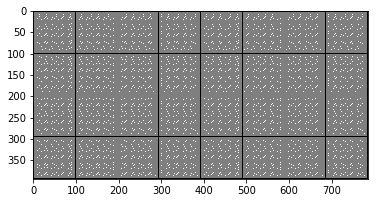

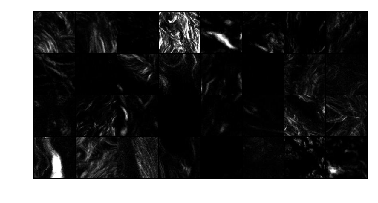

===> Avg. PSNR: 0.0081 dB


In [24]:
test()

In [ ]:
# restart
for epoch in range(1, 5 + 1):
    train(epoch)
#     test()
#     checkpoint(epoch)

lossMSE: 0.2632025480270386 lossSSIM: 0.0014457108336500823
===> Epoch[1](0/25343): Loss: 0.2646
lossMSE: 0.26612138748168945 lossSSIM: 0.0015527019859291613
===> Epoch[1](50/25343): Loss: 0.2677
lossMSE: 0.2585975229740143 lossSSIM: 0.001472305040806532
===> Epoch[1](100/25343): Loss: 0.2601
lossMSE: 0.26473793387413025 lossSSIM: 0.0014282198098953813
===> Epoch[1](150/25343): Loss: 0.2662
lossMSE: 0.26187270879745483 lossSSIM: 0.0013934792659711093
===> Epoch[1](200/25343): Loss: 0.2633
lossMSE: 0.25140324234962463 lossSSIM: 0.0015343354898504913
===> Epoch[1](250/25343): Loss: 0.2529
lossMSE: 0.2606308162212372 lossSSIM: 0.0013728057383559644
===> Epoch[1](300/25343): Loss: 0.2620
lossMSE: 0.2589508295059204 lossSSIM: 0.0014198314456734806
===> Epoch[1](350/25343): Loss: 0.2604
lossMSE: 0.26372644305229187 lossSSIM: 0.0014964787987992167
===> Epoch[1](400/25343): Loss: 0.2652
lossMSE: 0.2637883126735687 lossSSIM: 0.0014684224734082818
===> Epoch[1](450/25343): Loss: 0.2653
lossMSE: 

lossMSE: 0.26166632771492004 lossSSIM: 0.0013773419195786119
===> Epoch[1](4100/25343): Loss: 0.2630
lossMSE: 0.26097726821899414 lossSSIM: 0.0013939425407443196
===> Epoch[1](4150/25343): Loss: 0.2624
lossMSE: 0.25803142786026 lossSSIM: 0.001302531163673848
===> Epoch[1](4200/25343): Loss: 0.2593
lossMSE: 0.26669275760650635 lossSSIM: 0.0013623689592350274
===> Epoch[1](4250/25343): Loss: 0.2681
lossMSE: 0.2686121165752411 lossSSIM: 0.001343481824733317
===> Epoch[1](4300/25343): Loss: 0.2700
lossMSE: 0.25318989157676697 lossSSIM: 0.0014438707439694554
===> Epoch[1](4350/25343): Loss: 0.2546
lossMSE: 0.2597745954990387 lossSSIM: 0.0014133427175693214
===> Epoch[1](4400/25343): Loss: 0.2612
lossMSE: 0.26219940185546875 lossSSIM: 0.0013670851767528802
===> Epoch[1](4450/25343): Loss: 0.2636
lossMSE: 0.2613004446029663 lossSSIM: 0.0014613691892009228
===> Epoch[1](4500/25343): Loss: 0.2628
lossMSE: 0.25505679845809937 lossSSIM: 0.0013247470487840474
===> Epoch[1](4550/25343): Loss: 0.256

lossMSE: 0.26717886328697205 lossSSIM: 0.0014737882884219289
===> Epoch[1](8200/25343): Loss: 0.2687
lossMSE: 0.27285611629486084 lossSSIM: 0.001492645824328065
===> Epoch[1](8250/25343): Loss: 0.2743
lossMSE: 0.2638576328754425 lossSSIM: 0.0014348973927553743
===> Epoch[1](8300/25343): Loss: 0.2653
lossMSE: 0.2521001696586609 lossSSIM: 0.0013131377636455
===> Epoch[1](8350/25343): Loss: 0.2534
lossMSE: 0.26617228984832764 lossSSIM: 0.001410012919222936
===> Epoch[1](8400/25343): Loss: 0.2676
lossMSE: 0.2551718056201935 lossSSIM: 0.0014419700601138175
===> Epoch[1](8450/25343): Loss: 0.2566
lossMSE: 0.26765674352645874 lossSSIM: 0.0014464491396211088
===> Epoch[1](8500/25343): Loss: 0.2691
lossMSE: 0.2699723243713379 lossSSIM: 0.001462705316953361
===> Epoch[1](8550/25343): Loss: 0.2714
lossMSE: 0.25277847051620483 lossSSIM: 0.0015605619410052896
===> Epoch[1](8600/25343): Loss: 0.2543
lossMSE: 0.26480600237846375 lossSSIM: 0.001494496304076165
===> Epoch[1](8650/25343): Loss: 0.2663
l

lossMSE: 0.25460338592529297 lossSSIM: 0.0015149338287301362
===> Epoch[1](12300/25343): Loss: 0.2561
lossMSE: 0.26322808861732483 lossSSIM: 0.0013682925200555474
===> Epoch[1](12350/25343): Loss: 0.2646
lossMSE: 0.2658911347389221 lossSSIM: 0.0013874154828954488
===> Epoch[1](12400/25343): Loss: 0.2673
lossMSE: 0.25575020909309387 lossSSIM: 0.0014147156034596264
===> Epoch[1](12450/25343): Loss: 0.2572
lossMSE: 0.26527515053749084 lossSSIM: 0.0014806604012846947
===> Epoch[1](12500/25343): Loss: 0.2668
lossMSE: 0.2600129544734955 lossSSIM: 0.0014561115531250834
===> Epoch[1](12550/25343): Loss: 0.2615
lossMSE: 0.2570435702800751 lossSSIM: 0.0014825943508185446
===> Epoch[1](12600/25343): Loss: 0.2585
lossMSE: 0.2655598521232605 lossSSIM: 0.0013592206814792007
===> Epoch[1](12650/25343): Loss: 0.2669
lossMSE: 0.2611922025680542 lossSSIM: 0.0014807353145442903
===> Epoch[1](12700/25343): Loss: 0.2627
lossMSE: 0.2611812949180603 lossSSIM: 0.0015139430179260671
===> Epoch[1](12750/25343):

lossMSE: 0.25930145382881165 lossSSIM: 0.0014628710341639817
===> Epoch[1](16350/25343): Loss: 0.2608
lossMSE: 0.26025429368019104 lossSSIM: 0.0013711928331758827
===> Epoch[1](16400/25343): Loss: 0.2616
lossMSE: 0.259597510099411 lossSSIM: 0.001415759150404483
===> Epoch[1](16450/25343): Loss: 0.2610
lossMSE: 0.2655981183052063 lossSSIM: 0.0014731327537447214
===> Epoch[1](16500/25343): Loss: 0.2671
lossMSE: 0.2550073266029358 lossSSIM: 0.0016019725590012968
===> Epoch[1](16550/25343): Loss: 0.2566
lossMSE: 0.25537943840026855 lossSSIM: 0.0015460472786799073
===> Epoch[1](16600/25343): Loss: 0.2569
lossMSE: 0.2586551308631897 lossSSIM: 0.0013418497110251337
===> Epoch[1](16650/25343): Loss: 0.2600
lossMSE: 0.2629307210445404 lossSSIM: 0.0015131992986425757
===> Epoch[1](16700/25343): Loss: 0.2644
lossMSE: 0.26616135239601135 lossSSIM: 0.0013999616203363985
===> Epoch[1](16750/25343): Loss: 0.2676
lossMSE: 0.2636171579360962 lossSSIM: 0.001493313757237047
===> Epoch[1](16800/25343): Lo

lossMSE: 0.26587796211242676 lossSSIM: 0.001425100606866181
===> Epoch[1](20450/25343): Loss: 0.2673
lossMSE: 0.26144030690193176 lossSSIM: 0.0014413756434805691
===> Epoch[1](20500/25343): Loss: 0.2629
lossMSE: 0.2644229531288147 lossSSIM: 0.0014857847127132118
===> Epoch[1](20550/25343): Loss: 0.2659
lossMSE: 0.2712276875972748 lossSSIM: 0.0013953571615274996
===> Epoch[1](20600/25343): Loss: 0.2726
lossMSE: 0.2626590132713318 lossSSIM: 0.0014224676415324211
===> Epoch[1](20650/25343): Loss: 0.2641
lossMSE: 0.2668479084968567 lossSSIM: 0.0015081146266311407
===> Epoch[1](20700/25343): Loss: 0.2684
lossMSE: 0.26696646213531494 lossSSIM: 0.0014597965346183628
===> Epoch[1](20750/25343): Loss: 0.2684
lossMSE: 0.2690403461456299 lossSSIM: 0.0014470167516265064
===> Epoch[1](20800/25343): Loss: 0.2705
lossMSE: 0.26173803210258484 lossSSIM: 0.0014643586473539472
===> Epoch[1](20850/25343): Loss: 0.2632
lossMSE: 0.26115861535072327 lossSSIM: 0.0014626835763920099
===> Epoch[1](20900/25343):